In [1]:
!nvidia-smi

Thu May 21 11:50:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 645kB 3.5MB/s 
     |████████████████████████████████| 1.1MB 17.7MB/s 
     |████████████████████████████████| 3.8MB 24.4MB/s 
     |████████████████████████████████| 890kB 58.8MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/165-roBERTa_base/'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [6]:
import json, warnings, shutil
from scripts_step_lr_schedulers import *
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [0]:
# Unzip files
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/fold_1.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/fold_2.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/fold_3.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/fold_4.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/fold_5.tar.gz'

In [8]:
database_base_path = COLAB_BASE_PATH + 'Data/complete_96/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

,textID,text,selected_text,sentiment,jaccard,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,35,7,7,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,8,10,2,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,11,5,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,14,5,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,74,13,14,3,train,train,validation,train,train


# Model parameters

In [0]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 32,
  "EPOCHS": 5,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 5,
  "question_size": 4,
  "N_FOLDS": 5,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 1.87e-06


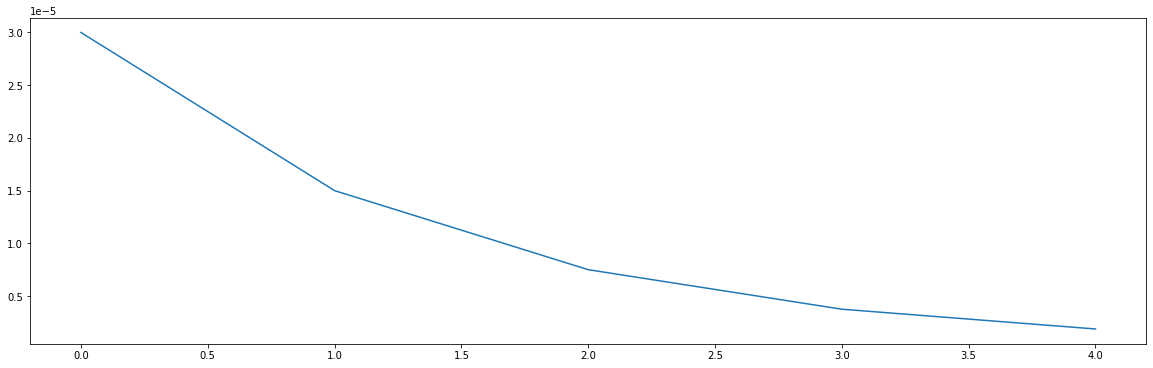

In [11]:
LR_MIN = 1e-6
LR_MAX = config['LEARNING_RATE']
LR_EXP_DECAY = .5

@tf.function
def lrfn(epoch):
    lr = LR_MAX * LR_EXP_DECAY**epoch
    if lr < LR_MIN:
        lr = LR_MIN
    return lr
    
rng = [i for i in range(config['EPOCHS'])]
y = [lrfn(x) for x in rng]

fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})

    x_start = layers.Dropout(.1)(last_hidden_state) 
    x_start = layers.Dense(1)(x_start)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)

    x_end = layers.Dropout(.1)(last_hidden_state) 
    x_end = layers.Dense(1)(x_end)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    return model

# Train

In [13]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
k_fold_best = k_fold.copy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    base_data_path = 'fold_%d/' % (n_fold)

    # Load data
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']

    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss_start = loss_fn(y['y_start'], probabilities[0], label_smoothing=0.2)
                loss_end = loss_fn(y['y_end'], probabilities[1], label_smoothing=0.2)
                loss = tf.math.add(loss_start, loss_end)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # update metrics
            train_loss.update_state(loss)
            train_loss_start.update_state(loss_start)
            train_loss_end.update_state(loss_end)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss_start = loss_fn(y['y_start'], probabilities[0])
            loss_end = loss_fn(y['y_end'], probabilities[1])
            loss = tf.math.add(loss_start, loss_end)
            # update metrics
            valid_loss.update_state(loss)
            valid_loss_start.update_state(loss_start)
            valid_loss_end.update_state(loss_end)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)//step_size))
    loss_fn = losses.categorical_crossentropy
    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    train_loss_start = metrics.Sum()
    valid_loss_start = metrics.Sum()
    train_loss_end = metrics.Sum()
    valid_loss_end = metrics.Sum()
        
    metrics_dict = {'loss': train_loss, 'loss_start': train_loss_start, 'loss_end': train_loss_end, 
                    'val_loss': valid_loss, 'val_loss_start': valid_loss_start, 'val_loss_end': valid_loss_end}
        
    history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                         step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], 
                         (MODEL_BASE_PATH + model_path), save_last=False)
    
    history_list.append(history)
    model.save_weights(MODEL_BASE_PATH +'last_' + model_path)
    
    # Make predictions (last model)
    x_train = np.load(base_data_path + 'x_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE']))
    valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE']))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold)] = k_fold['end_fold_%d' % (n_fold)].astype(int)
    k_fold['start_fold_%d' % (n_fold)] = k_fold['start_fold_%d' % (n_fold)].astype(int)
    k_fold['end_fold_%d' % (n_fold)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold)].clip(0, k_fold['end_fold_%d' % (n_fold)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold)].fillna(k_fold["text"], inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold)] = k_fold.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)

    # Make predictions (best model)
    model.load_weights(MODEL_BASE_PATH + model_path)
    train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE']))
    valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE']))
    
    k_fold_best.loc[k_fold_best['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold_best.loc[k_fold_best['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold_best.loc[k_fold_best['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold_best.loc[k_fold_best['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold_best['end_fold_%d' % (n_fold)] = k_fold_best['end_fold_%d' % (n_fold)].astype(int)
    k_fold_best['start_fold_%d' % (n_fold)] = k_fold_best['start_fold_%d' % (n_fold)].astype(int)
    k_fold_best['end_fold_%d' % (n_fold)].clip(0, k_fold_best['text_len'], inplace=True)
    k_fold_best['start_fold_%d' % (n_fold)].clip(0, k_fold_best['end_fold_%d' % (n_fold)], inplace=True)
    k_fold_best['prediction_fold_%d' % (n_fold)] = k_fold_best.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold_best['prediction_fold_%d' % (n_fold)].fillna(k_fold_best["text"], inplace=True)
    k_fold_best['jaccard_fold_%d' % (n_fold)] = k_fold_best.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)


FOLD: 1
Train for 687 steps, validate for 171 steps
Instructions for updating:
renamed to `run`

EPOCH 1/5
time: 276.5s loss: 4.4712 loss_start: 2.2020 loss_end: 2.2692 val_loss: 1.9698 val_loss_start: 0.9847 val_loss_end: 0.9851
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/165-roBERTa_base/model_fold_1.h5"

EPOCH 2/5
time: 266.9s loss: 4.0537 loss_start: 2.0228 loss_end: 2.0309 val_loss: 1.9363 val_loss_start: 0.9937 val_loss_end: 0.9426
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/165-roBERTa_base/model_fold_1.h5"

EPOCH 3/5
time: 269.2s loss: 3.9388 loss_start: 1.9725 loss_end: 1.9663 val_loss: 1.9069 val_loss_start: 0.9732 val_loss_end: 0.9337
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/165-roBERTa_base/model_fold_1.h5"

EPOCH 4/5
time: 268.5s loss: 3.8668 loss_start: 1.9467 loss_end: 1.9201 val_loss: 1.90

# Model loss graph

Fold: 1


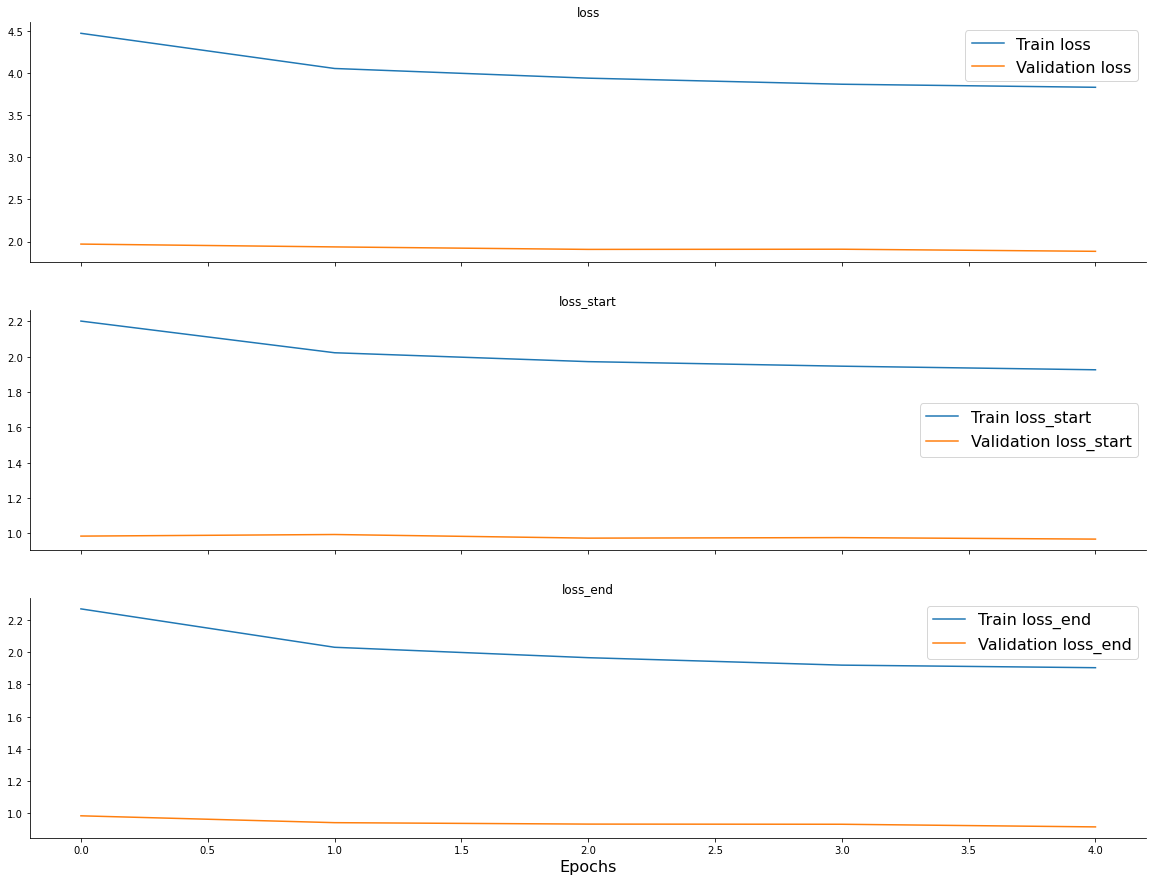

Fold: 2


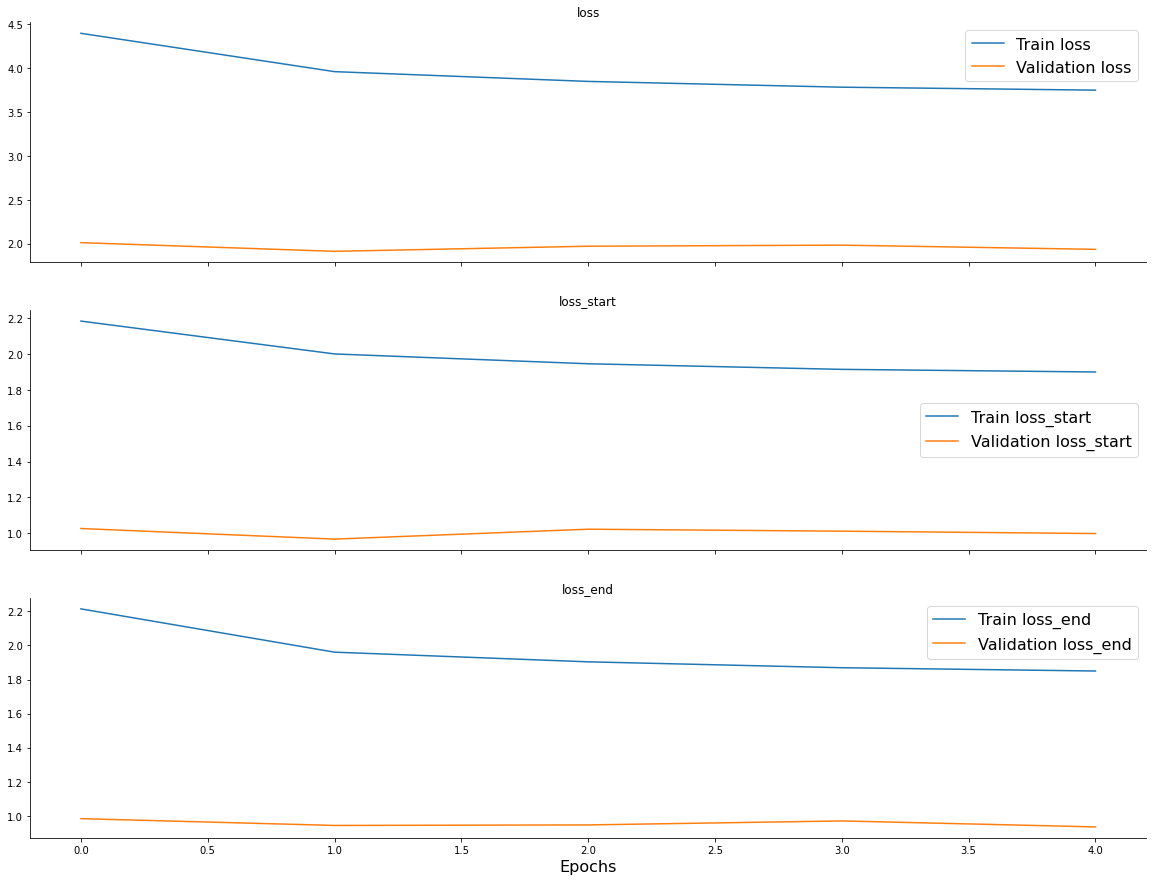

Fold: 3


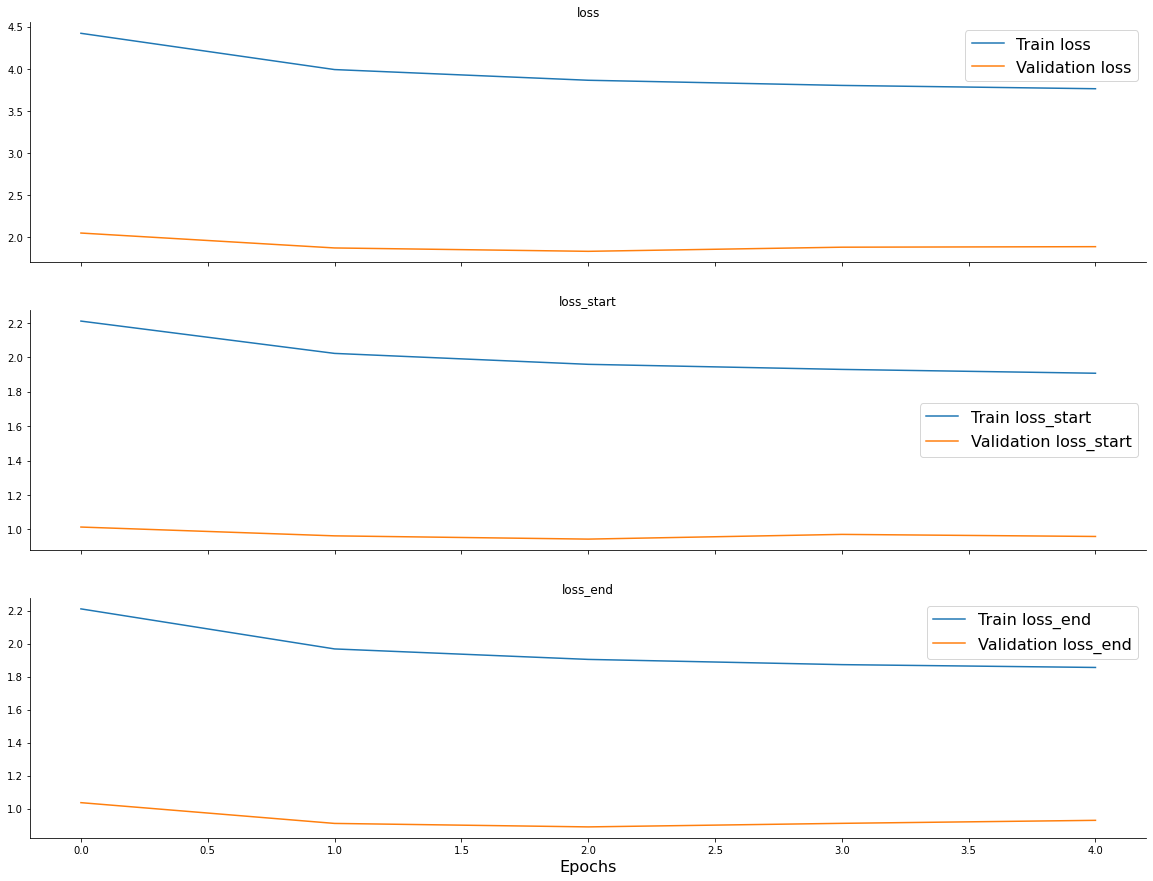

Fold: 4


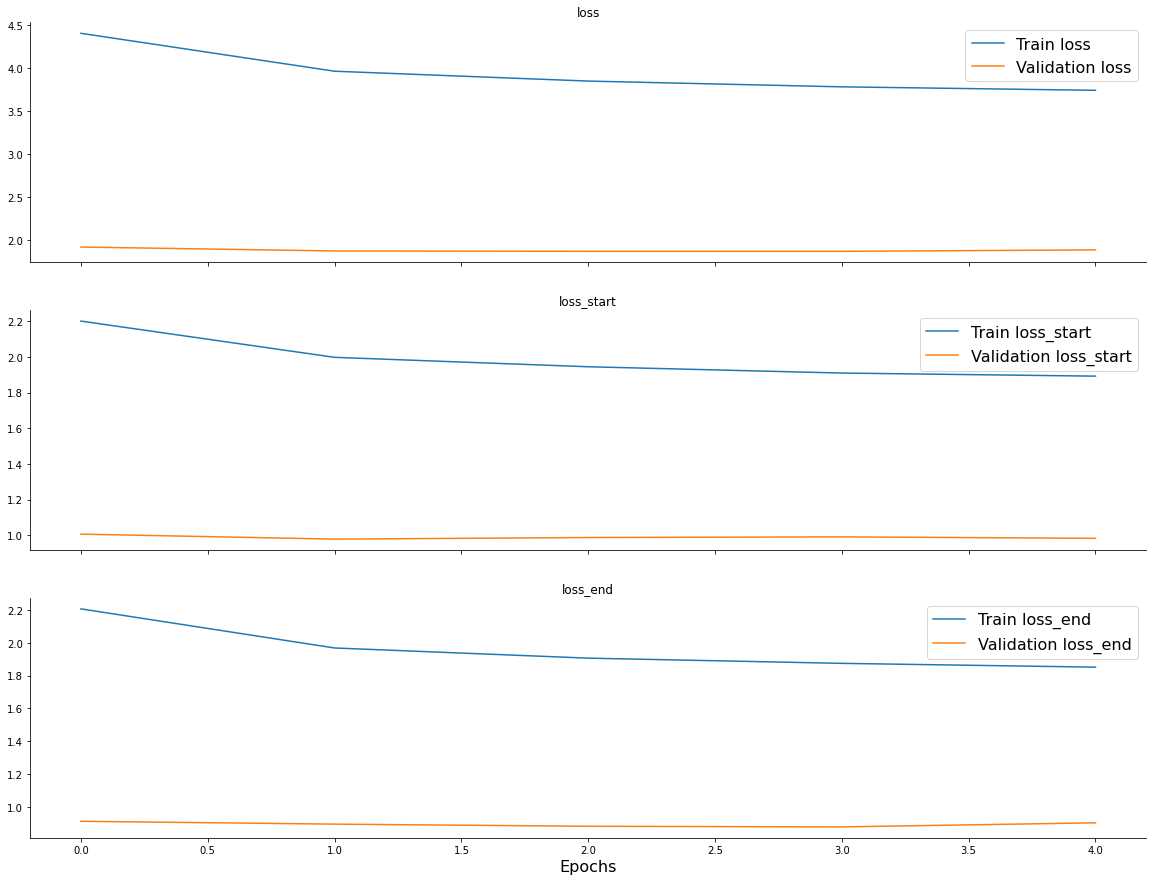

Fold: 5


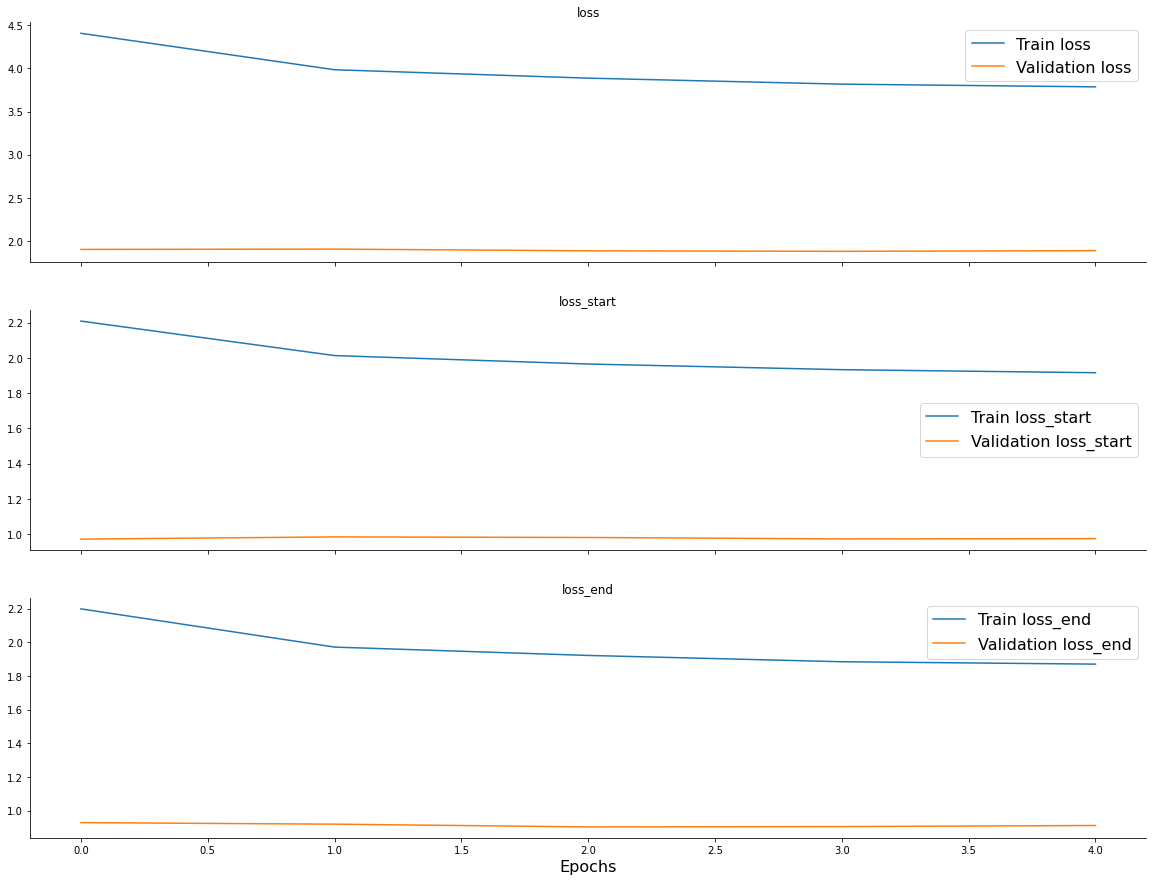

In [14]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation (last model)

In [15]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.764692,0.707552,0.057140,0.752454,0.701401,0.771440,0.703279,0.765138,0.716102,0.773570,0.705737,0.760860,0.711242
Sentiment negative,0.631529,0.525376,0.106153,0.613648,0.513408,0.645215,0.519220,0.629280,0.537045,0.644148,0.532102,0.625356,0.525106
Sentiment neutral,0.973464,0.970655,0.002809,0.967061,0.964913,0.974796,0.972452,0.975298,0.973931,0.976044,0.969823,0.974123,0.972158
Sentiment positive,0.614986,0.531904,0.083082,0.600336,0.530343,0.622491,0.521318,0.616058,0.544564,0.628609,0.521179,0.607438,0.542116
0 <= text wordCnt < 3,0.868961,0.854272,0.014688,0.873252,0.820896,0.870871,0.866446,0.867588,0.868766,0.873939,0.831197,0.859155,0.884058
3 <= text wordCnt < 10,0.811233,0.769906,0.041326,0.809787,0.761459,0.814960,0.769710,0.807259,0.781431,0.818370,0.762105,0.805786,0.774827
10 <= text wordCnt < 30,0.736244,0.669428,0.066816,0.717978,0.664580,0.744366,0.664815,0.738450,0.677903,0.746522,0.669813,0.733905,0.670027
30 <= text wordCnt < 100,0.708321,0.614293,0.094028,0.676375,0.615228,0.742904,0.481900,0.745693,0.580208,0.712004,0.654907,0.664630,0.739223
0 <= selected text wordCnt < 3,0.719248,0.621318,0.097930,0.697821,0.603617,0.724351,0.611757,0.725870,0.635494,0.745310,0.631971,0.702887,0.623753


# Model evaluation (best model)

In [16]:
display(evaluate_model_kfold(k_fold_best, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.749831,0.704440,0.045391,0.735578,0.695895,0.741300,0.699092,0.748405,0.711351,0.769771,0.703814,0.754099,0.712048
Sentiment negative,0.606191,0.522561,0.083630,0.585981,0.508941,0.592233,0.515130,0.603109,0.534581,0.634963,0.528088,0.614668,0.526066
Sentiment neutral,0.972190,0.970512,0.001677,0.962940,0.962282,0.973673,0.973705,0.974563,0.974163,0.975530,0.969764,0.974244,0.972648
Sentiment positive,0.592024,0.524674,0.067350,0.576725,0.520171,0.575474,0.509993,0.587156,0.531279,0.625439,0.518736,0.595323,0.543191
0 <= text wordCnt < 3,0.865062,0.851972,0.013091,0.870629,0.817164,0.865165,0.859823,0.862406,0.864829,0.870303,0.837607,0.856808,0.880435
3 <= text wordCnt < 10,0.800378,0.768688,0.031689,0.798830,0.759669,0.792834,0.766961,0.795248,0.776714,0.814579,0.762591,0.800397,0.777508
10 <= text wordCnt < 30,0.718836,0.665384,0.053452,0.697533,0.657235,0.709055,0.660171,0.718971,0.673032,0.742564,0.666187,0.726056,0.670296
30 <= text wordCnt < 100,0.689596,0.600550,0.089046,0.645793,0.584665,0.701457,0.464299,0.704362,0.583665,0.721437,0.654907,0.674931,0.715214
0 <= selected text wordCnt < 3,0.689767,0.613140,0.076627,0.664345,0.591714,0.670040,0.605024,0.686250,0.618266,0.717505,0.605183,0.710694,0.645511


# Visualize predictions

In [17]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,jaccard,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3,prediction_fold_4,jaccard_fold_4,prediction_fold_5,jaccard_fold_5
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,sooo sad,1.000000,sooo sad,1.000000,sooo sad,1.000000,sooo sad,1.000000,sooo sad,1.000000
2,my boss is bullying me...,bullying me,negative,0.166667,bullying,0.500000,bullying me...,0.333333,bullying,0.500000,bullying me...,0.333333,bullying me...,0.333333
3,what interview! leave me alone,leave me alone,negative,0.600000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,"sons of ****,",1.000000,"sons of ****,",1.000000,"****,",0.333333,"****,",0.333333,"sons of ****,",1.000000
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,some shameless plugging for the best rangers f...,0.833333,some shameless plugging for the best rangers f...,0.833333,some shameless plugging for the best rangers f...,0.833333
6,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,0.500000,cooler.,0.200000,wow...,0.200000,wow... u just became cooler.,1.000000,wow... u just became cooler.,1.000000,wow... u just became cooler.,1.000000
